In [34]:
import gym
import random
import numpy as np
from tqdm import tqdm
from __future__ import annotations
from matplotlib.patches import Patch
from collections import defaultdict

In [35]:
env = gym.make("Blackjack-v1", sab=True)

In [36]:
obs_space = env.observation_space
action_space = env.action_space
print("The observation space: {}".format(obs_space))
print("The action space: {}".format(action_space))

The observation space: Tuple(Discrete(32), Discrete(11), Discrete(2))
The action space: Discrete(2)


In [56]:
class Agent():
    
    def __init__(self, env):
        """
        Initialises the agent by determining if the environment 
        is discrete or continuous, and then defines the action space
        """
        self.is_discrete = type(env.action_space) == gym.spaces.discrete.Discrete
        
        if self.is_discrete:
            self.action_size = env.action_space.n
            print(f'Action size : {self.action_size}')
            
        else:
            self.action_low = env.action_space.low
            self.action_high = env.action_space.high
            self.action_shape = env.action_space.shape
            
            
    def get_action(self):
        """
        Returns a random action from the action space
        """
        if self.is_discrete:
            return env.action_space.sample()
        
        else:
            return np.random.uniform(self.action_low,
                                    self.action_high,
                                     self.action_shape)

In [87]:
class QAgent(Agent):
    
    def __init__(self, env, discount_rate=0.95, learning_rate=0.01, initial_eps=1.0, min_eps=0.1, eps_decay=0.01):
        """
        Initialises a discrete Q-learning agent
        params:
            env: The game environment
            discount_rate: The discount rate for the agent
            learning_rate: The learning rate for the agent
            initial_eps: The initial epsilon value for choosing an action
            min_eps: The value at which epsilon should stop decaying
            eps_decay: The value that should be subtracted from epsilon each time it decays"""
        super().__init__(env)
        
        #setting constants
        self.eps = initial_eps
        self.eps_decay = eps_decay
        self.min_eps = min_eps
        
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        
        #used to track epislon values at each decay
        self.epsilons = []
        
        #creating the q table
        self.build_model()
        
    def build_model(self):
        """
        Initialises the q tables
        """
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))

        
    def get_action(self, state):
        """
        Picks the optimal action with a probability
        of 1-epsilon, and else will just choose a 
        random action
        """
        if random.random() < self.eps:
            return super().get_action()
        else:
            return int(np.argmax(self.q_table[state]))
        
    def train(self, experience):
        """
        Updates the Q-table based on an action and the reward
        If the end of an episode is reached, eplison is decayed
        """
        state, action, next_state, reward, terminated, truncated, info = experience
        
        #updating the q value for the state-action pair
        future_q_value = (not terminated)*np.max(self.q_table[next_state])
        temporal_difference = reward + self.discount_rate*future_q_value - self.q_table[state][action]
        self.q_table[state][action] = self.q_table[state][action] + self.learning_rate*temporal_difference

        # decay epsilon over time
        if terminated or truncated:
            self.decay_epsilon()
            
    def decay_epsilon(self):
        """
        Decays epsilon by subtracting a value from epsilon until
        the minimum value is reached"""
        self.eps = max(self.min_eps, self.eps - self.eps_decay)
        self.epsilons.append(self.eps)
        
        
    

Training the agent

In [104]:
n_episodes = 100_000

# defining the discount and learning rate
lr = 0.1
dr = 0.9
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0.01

# putting a wrapper on the environment to record rewards
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

# initialising the agent
q_agent = QAgent(env, learning_rate=lr, discount_rate=dr,
                initial_eps = start_epsilon, eps_decay = epsilon_decay,
                min_eps = final_epsilon)

terminated, truncated = False, False

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    
    while not done:
        action = q_agent.get_action(obs)
        new_obs, reward, terminated, truncated, info = env.step(action)
        q_agent.train((obs, action, new_obs, reward, terminated, truncated, info))
        obs = new_obs
        done = terminated or truncated

Action size : 2


100%|█████████████████████████████████| 100000/100000 [00:22<00:00, 4387.77it/s]


Below is code plotting the rewards for each episodes, the episode lengths and the log of the epsilon values as they decay.

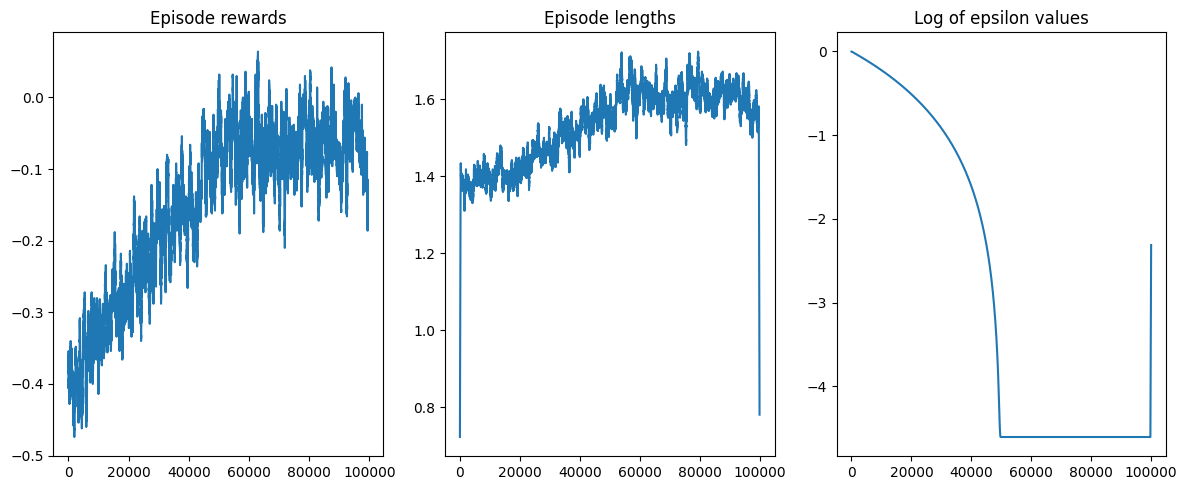

In [105]:
import matplotlib.pyplot as plt

rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Log of epsilon values")
training_error_moving_average = (
    np.convolve(np.log(np.array(q_agent.epsilons)), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()
